In [11]:
# Install once
!pip install -q transformers scikit-learn pandas tqdm

from transformers import BertTokenizer, XLMRobertaTokenizer
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import Dataset, DataLoader
import os, zipfile, glob, pandas as pd

In [12]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

In [13]:
# Tokenizers

BERT_TOK = BertTokenizer.from_pretrained('bert-base-uncased')
XLMR_TOK = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

## 2. Dataset (replace with your CSV)

In [14]:
OUTER_ZIP = "Basics of BERT and XLM-RoBERTa - PyTorch - 2.zip"
with zipfile.ZipFile(OUTER_ZIP) as z:
    z.extractall("data")

root_candidates = glob.glob("data/*BERT*XLM*")
if not root_candidates:
    raise FileNotFoundError("Aucun dossier correspondant trouvé après extraction.")
root = root_candidates[0]
print("root dir →", root)
print("contenu :", os.listdir(root))

for inner_zip in glob.glob(os.path.join(root, "*.zip")):
    with zipfile.ZipFile(inner_zip) as z:
        z.extractall(root)
    print("décompressé :", inner_zip)

# 3) Chargement des CSV

TRAIN_CSV = os.path.join(root, "train.csv")
TEST_CSV  = os.path.join(root, "test.csv")

train_df = pd.read_csv(TRAIN_CSV)
print("\nTrain preview :\n", train_df.head())
print("\nLabel distribution :\n", train_df['label'].value_counts())

test_df = pd.read_csv(TEST_CSV) if os.path.exists(TEST_CSV) else None
print("\nTest set shape :", test_df.shape if test_df is not None else "Pas de test.csv")

root dir → data/Basics of BERT and XLM-RoBERTa - PyTorch
contenu : ['sample_submission.csv', 'train.csv.zip', 'test.csv.zip', 'test.csv', 'train.csv']
décompressé : data/Basics of BERT and XLM-RoBERTa - PyTorch/train.csv.zip
décompressé : data/Basics of BERT and XLM-RoBERTa - PyTorch/test.csv.zip

Train preview :
            id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accompl

In [15]:
print(train_df.columns)

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')


## 3. Stratified 5-fold

In [16]:
X1 = train_df['premise'].values
X2 = train_df['hypothesis'].values
y  = train_df['label'].values

# -------------------------------------------------
# 2) Dataset adapté aux paires de phrases
# -------------------------------------------------
class NLIDataset(Dataset):
    def __init__(self, premises, hypotheses, labels, tokenizer, max_len=256):
        self.p, self.h, self.labels, self.tok = premises, hypotheses, labels, tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = self.tok.encode_plus(
            self.p[idx],               # première phrase
            self.h[idx],               # deuxième phrase
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# -------------------------------------------------
# 3) 5-fold stratifié
# -------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(skf.split(X1, y))
print(f"Created {len(folds)} folds")


Created 5 folds


## 4. Tokenisation + Dataset PyTorch

In [17]:
train_idx, val_idx = folds[0]
train_ds = NLIDataset(X1[train_idx], X2[train_idx], y[train_idx], BERT_TOK, max_len=128)
val_ds   = NLIDataset(X1[val_idx],   X2[val_idx],   y[val_idx],   BERT_TOK, max_len=128)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8)

print(next(iter(train_loader)))

{'input_ids': tensor([[  101,  2019,  3720,  ...,     0,     0,     0],
        [  101, 15039, 12267,  ...,     0,     0,     0],
        [  101,  2122,  3513,  ...,     0,     0,     0],
        ...,
        [  101,  2295, 14491,  ...,     0,     0,     0],
        [  101,  2019,  3452,  ...,     0,     0,     0],
        [  101,  2027,  2024,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 1, 2, 0, 2, 0, 0, 2])}


## 5.Fine-tune


Modèle BERT pour classification (3 classes NLI)


In [18]:
from transformers import BertForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=3                       # entailment, neutral, contradiction
).to(device)


 Optimiseur + fonction de perte


In [19]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

Boucle d'entraînement + validation

In [20]:
epochs = 3
train_losses, val_losses, val_accs = [], [], []

for epoch in range(epochs):
    # --- phase train ---
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        att_mask  = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=att_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # --- phase validation ---
    model.eval()
    epoch_val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            att_mask  = batch['attention_mask'].to(device)
            labels    = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=att_mask, labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch + 1} | "
          f"Train loss {train_losses[-1]:.4f} | "
          f"Val loss {val_losses[-1]:.4f} | "
          f"Val acc {val_accs[-1]:.4f}")


Epoch 1 | Train loss 1.0998 | Val loss 1.1092 | Val acc 0.3350
Epoch 2 | Train loss 1.1037 | Val loss 1.1002 | Val acc 0.3350
Epoch 3 | Train loss 1.1011 | Val loss 1.1011 | Val acc 0.3449


# Étape 7 : visualisation rapide

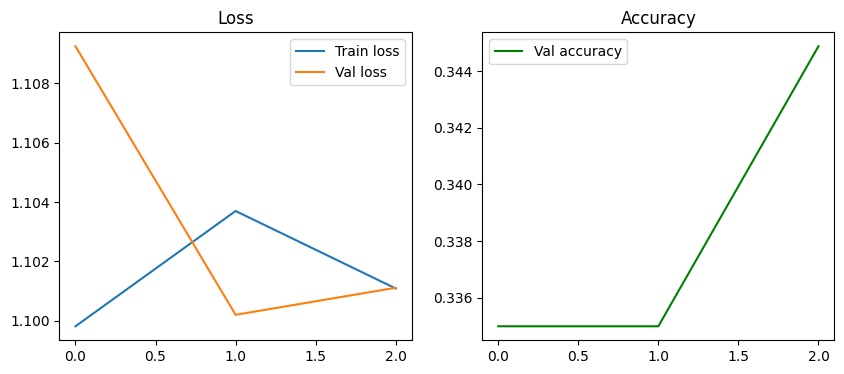

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses,   label='Val loss')
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val accuracy', color='green')
plt.legend(); plt.title("Accuracy")
plt.show()

inférence sur le jeu de test


In [23]:
if test_df is not None:
    test_p = test_df['premise'].values
    test_h = test_df['hypothesis'].values
    test_ds = NLIDataset(test_p, test_h, [0]*len(test_p), BERT_TOK, max_len=128)  # labels fictifs
    test_loader = DataLoader(test_ds, batch_size=8)

    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            att_mask  = batch['attention_mask'].to(device)
            logits = model(input_ids, attention_mask=att_mask).logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

    sub = pd.DataFrame({'id': test_df['id'], 'prediction': preds})
    sub.to_csv('submission.csv', index=False)
    print("submission.csv ready!")

submission.csv ready!
